In [147]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.cluster import KMeans
from sklearn import preprocessing

import urllib
from math import sqrt
from sklearn import tree
import pylab as pl
import pandas as pd
import StringIO
#from pydot import graph_from_dot_data as gdot
from sklearn.externals.six import StringIO 

We use the data of the Wisconsin Diagnostic Breast Cancer (WDBC) to perform the k-means cluster analysis. We try to identify clustering of specific images in the database from which data such as radius, texture, perimeter, area (mean) are receovered.   The idea behind the analysis is to understand if they are correleted with the cancer being malignant (cancerous) or benign (non-cancerous).

In [148]:
# URL for the Wisconsin Diagnostic Breast Cancer (WDBC) (UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
# download the file
raw_data = urllib.urlopen(url)
# load the file as a numpy matrix
attributes = ['id','cancer_type','mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area',
       'mean_smoothness', 'mean_compactness', 'mean_concavity',
       'mean_concave_points', 'mean_symmetry', 'mean_fractal_dimension',
       'radius_error', 'texture_error', 'perimeter_error', 'area_error',
       'smoothness_error', 'compactness_error', 'concavity_error',
       'concave_points_error', 'symmetry_error', 'fractal_dimension_error',
       'worst_radius', 'worst_texture', 'worst_perimeter', 'worst_area',
       'worst_smoothness', 'worst_compactness', 'worst_concavity',
       'worst_concave_points', 'worst_symmetry', 'worst_fractal_dimension']
bcd =  np.genfromtxt(raw_data, delimiter=',', dtype=None, names= attributes)

In [149]:
# Convert the numpy array into Pandas DataFrame
bcdf = pd.DataFrame(data=bcd, columns=attributes)

In [150]:
#Clean the datasets
data_clean = bcdf.dropna()

In [151]:
#Data managment
recode1 = {"M":1, "B":0}
data_clean['cancer_type']= data_clean['cancer_type'].map(recode1)

We select the clustering variables for the analysis.

In [152]:
clustervars = data_clean[['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area',
       'mean_smoothness', 'mean_compactness', 'mean_concavity',
       'mean_concave_points', 'mean_symmetry', 'mean_fractal_dimension',
       'radius_error', 'texture_error', 'perimeter_error', 'area_error',
       'smoothness_error', 'compactness_error', 'concavity_error',
       'concave_points_error', 'symmetry_error', 'fractal_dimension_error',
       'worst_radius', 'worst_texture', 'worst_perimeter', 'worst_area',
       'worst_smoothness', 'worst_compactness', 'worst_concavity',
       'worst_concave_points', 'worst_symmetry', 'worst_fractal_dimension']]
cancer_data = data_clean.cancer_type

We make a copy to use the original dataset in the later analysis.

In [153]:
clus = clustervars.copy()

We standardize the predictors so that all the quantities have mean=0 and std=1.

In [154]:
for l in clus.columns:
    clus[l]=preprocessing.scale(clus[l].astype('float64'))

As usual we split data into train (70%) and test set (30%). 

In [155]:
clus_train, clus_test = train_test_split(clus, test_size=.3, random_state=123)

We begin the k-means cluster analysis with k=[1-9] clusters and calculate the mean Euclidian distance amongst the different clusters.

In [156]:
from scipy.spatial.distance import cdist
clusters=range(1,9)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    meandist.append(sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1))
                    /clus_train.shape[0])

We plot the distance amongst clusters centroid for different number of clusters.
The Elbow Method is then used to identify the number of clusters to choose.

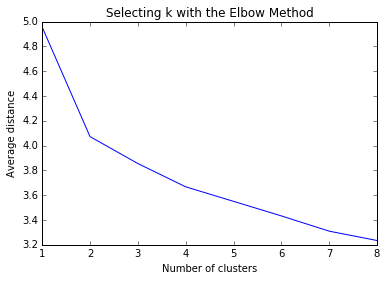

In [157]:
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')

The plot above is not completely conclusive and we could use 2,3, or 4 clusters respectively.

In [158]:
# Interpret 2 cluster solution
model2=KMeans(n_clusters=2)

model2.fit(clus_train)

clusassign=model2.predict(clus_train)

To plot the cluster in a 2-D plot we have to use a dimensionality reduction algorithm such as PCA to be able to visualize the data. 

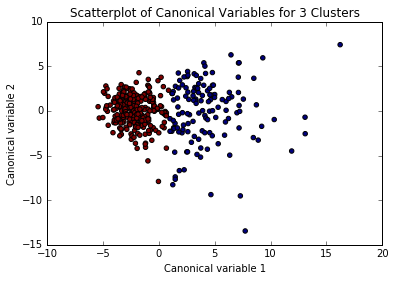

In [159]:
# plot clusters
from sklearn.decomposition import PCA

pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(clus_train)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model2.labels_,)

plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 3 Clusters')
plt.show()

We do the same for k=3.

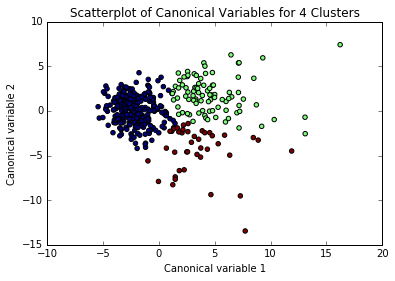

In [160]:
# Interpret 3 cluster solution
model3=KMeans(n_clusters=3)

model3.fit(clus_train)

clusassign3=model3.predict(clus_train)

# plot clusters

from sklearn.decomposition import PCA

pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(clus_train)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model3.labels_,)

plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 4 Clusters')
plt.show()

Only the first and second cluster show a distinct grouping of the points. Adding and additional cluster wopuld only increase the variance in within each cluster.

We want to examine now the cluster variable means for each of the clusters. We can do that by merging the cluster assignment value for each of the model (in our case k=3) with the identifier variable specific to each element of the dataset.

In [161]:
# create a unique identifier variable from the index for the 
# cluster training data to merge with the cluster assignment variable
clus_train.reset_index(level=0, inplace=True)
# create a list that has the new index variable
cluslist=list(clus_train['index'])
# create a list of cluster assignments
labels=list(model3.labels_)
# combine index variable list with cluster assignment list into a dictionary
newlist=dict(zip(cluslist, labels))
newlist
# convert newlist dictionary to a dataframe
newclus=pd.DataFrame.from_dict(newlist, orient='index')
newclus
# rename the cluster assignment column
newclus.columns = ['cluster']

In [162]:
# now do the same for the cluster assignment variable
# create a unique identifier variable from the index for the 
# cluster assignment dataframe 
# to merge with cluster training data
newclus.reset_index(level=0, inplace=True)
# merge the cluster assignment dataframe with the cluster training variable dataframe
# by the index variable
merged_train=pd.merge(clus_train, newclus, on='index')
merged_train.head(n=100)
# cluster frequencies
merged_train.cluster.value_counts()

0    263
1     93
2     42
Name: cluster, dtype: int64

As we have already noticed most of the data are packed in cluster 0 (256) which is the most densely popupulated. We can now  calculate clustering variable means by cluster.

In [163]:
clustergrp = merged_train.groupby('cluster').mean()
print ("Clustering variable means by cluster")
print(clustergrp)

Clustering variable means by cluster
              index  mean_radius  mean_texture  mean_perimeter  mean_area  \
cluster                                                                     
0        302.969582    -0.444804     -0.207514       -0.463092  -0.448321   
1        250.774194     1.415984      0.631418        1.415889   1.418734   
2        244.928571    -0.303065      0.152560       -0.192711  -0.309238   

         mean_smoothness  mean_compactness  mean_concavity  \
cluster                                                      
0              -0.298211         -0.514345       -0.565356   
1               0.363704          0.806359        1.092298   
2               0.811707          1.468053        1.161281   

         mean_concave_points  mean_symmetry           ...             \
cluster                                               ...              
0                  -0.557442      -0.324499           ...              
1                   1.325461       0.393731       

We see that cluster 0 and 2 are more separated but the data are also more spread out indicating less correlation amongst them compared to cluster 1. By looking at the results in the table above we can see that the cluster 1 has the largest value of mea_radius, mean_texture , mearn_perimeter and mean_area. The first group has instead the lowest value for all the previous features. The group 2 instead falls somewhere in between making us thinking that the model with k=2 might need further attention.

## Validation

We can now validate the clusters in training data by examining cluster differences in cancer using the analysis of variance to see if there are significant differences between clusters regarding the type of cancer in each of them.
First, we have to merge cancer with clustering variables and cluster assignment data cancer_data=data_clean['cancer_type'].

In [164]:
# split cancer data into train and test sets
cancer_train, cancer_test = train_test_split(cancer_data, test_size=.3, random_state=123)
cancer_train1=pd.DataFrame(cancer_train)
cancer_train1.reset_index(level=0, inplace=True)
merged_train_all=pd.merge(cancer_train1, merged_train, on='index')
sub1 = merged_train_all[['cancer_type', 'cluster']].dropna()

In [165]:
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi 

In this analysis we force cancer_type, which normally is a categorical variable, to be quantitative so that we can se in any of the clusters the percentage of cancer types.

In [167]:
gpamod = smf.ols(formula='cancer_type ~ C(cluster)', data=sub1).fit()
print (gpamod.summary())

                            OLS Regression Results                            
Dep. Variable:            cancer_type   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     328.4
Date:                Sat, 30 Apr 2016   Prob (F-statistic):           9.99e-85
Time:                        23:05:21   Log-Likelihood:                -78.164
No. Observations:                 398   AIC:                             162.3
Df Residuals:                     395   BIC:                             174.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           0.1027      0.018     

In [ ]:
print ('means for cancer_type by cluster')
m1= sub1.groupby('cluster').mean()
print (m1)

We can see that all in cluster 1 we have 100% cases of malignant cancer as expected from the analysis of the means of the 
features in the previous table.

In [168]:
# create a variable out of the index for the cluster training dataframe to merge on
clus_test.reset_index(level=0, inplace=True)

In [169]:
# create a list that has the new index variable
cluslistval=list(clus_test['index'])
# create a list of cluster assignments
labelsval=list(clusassign)
# combine index variable list with labels list into a dictionary
newlistval=dict(zip(cluslistval, clusassign))
newlistval
# convert newlist dictionary to a dataframe
newclusval=pd.DataFrame.from_dict(newlistval, orient='index')
newclusval
# rename the cluster assignment column
newclusval.columns = ['cluster']
# create a variable out of the index for the cluster assignment dataframe to merge on
newclusval.reset_index(level=0, inplace=True)
# merge the cluster assignment dataframe with the cluster training variable dataframe
# by the index variable
merged_test=pd.merge(clus_test, newclusval, on='index')
# cluster frequencies
merged_test.cluster.value_counts()

1    112
0     59
Name: cluster, dtype: int64

In [170]:
# calculate test data clustering variable means by cluster
clustergrpval = merged_test.groupby('cluster').mean()
print ("Test data clustering variable means by cluster")
print(clustergrpval)

Test data clustering variable means by cluster
              index  mean_radius  mean_texture  mean_perimeter  mean_area  \
cluster                                                                     
0        300.694915    -0.097880     -0.101520       -0.101051  -0.094827   
1        272.901786     0.033933     -0.040746        0.037243   0.040615   

         mean_smoothness  mean_compactness  mean_concavity  \
cluster                                                      
0              -0.144956         -0.110878       -0.108869   
1               0.170231          0.046115        0.042450   

         mean_concave_points  mean_symmetry           ...             \
cluster                                               ...              
0                  -0.148972      -0.065748           ...              
1                   0.063672       0.035392           ...              

         worst_radius  worst_texture  worst_perimeter  worst_area  \
cluster                              